In [ ]:
#Web scraping

In [24]:
from selenium import webdriver
import json
import os.path
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import time
import shutil
import re

In [25]:
month_nums = range(1,12)
month_abv = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [26]:
month_dict = dict(zip(month_abv, month_nums)) # Jan to 1, etc
num_to_month = dict(zip(month_nums, month_abv)) # 1 to Jan, etc

In [27]:
# Download chrome webdriver here: https://chromedriver.storage.googleapis.com/index.html?path=79.0.3945.36/
driver = webdriver.Chrome('/Users/yingyinxiao/Downloads/chromedriver') # change to your path for chromedriver
script_dir = '/Users/yingyinxiao/Documents//Assignment2' # change to your script directory path

In [10]:
def dates_scraper(st_yr, end_yr):
    total_dates = pd.Series()
    for curr_yr in range(st_yr, end_yr+1):
        url = 'https://en.wikipedia.org/wiki/20{}-{}_NBA_season'.format(curr_yr, curr_yr+1)
        driver.get(url)
        yr_finder = driver.find_element_by_xpath('/html/body/div[3]/div[3]/div[4]/div/table[1]/tbody/tr[4]/td')
        reg_season = yr_finder.text.split('\n')[0]
        range_reg_season = reg_season.split(' – ')
        start_date = range_reg_season[0]
        end_date = range_reg_season[1]
        daterange = pd.Series(pd.date_range(start_date, end_date))
        total_dates = total_dates.append(daterange)
    return total_dates.reset_index(drop=True)

In [5]:
def download_roto_file(date):
    url = 'http://rotoguru1.com/cgi-bin/hyday.pl?game=fd&mon={}&day={}&year={}'.format(date.month, date.day, date.year)
    driver.get(url)
    print('Got url:',str(date)[:10])
    
    soup = BeautifulSoup(driver.page_source, 'html5lib')

    json = soup.findAll('table')
    data = json[9]

    date_str = str(date)[:10]
    local_filename = 'A2_data/Roto_Data/Roto_html/roto_data_{}.html'.format(date_str)
    with open(local_filename, 'w') as f:

        for row in data:
            #print(row)

            f.write(str(row))

In [6]:
def scrape_roto_data(date):
    date_str = str(date)[:10]

    local_filename = 'A2_data/Roto_Data/Roto_html/roto_data_{}.html'.format(date_str)
    data= BeautifulSoup(open(local_filename))#,'html.parser')
    
    trs = data.findAll('tr')
    if len(trs) == 0:
        return None
    tds = [tr.findAll('td') for tr in trs]
    player_data = [tr.text for tr in trs]
    pattern = '[A-Za-z]+, [A-Za-z]+'
    prog = re.compile(pattern)
    #re.search(prog, player_data[0]).group(0)
    player_data_alt = [player[2:] if player[0] != 'C' else player[1:] for player in player_data]
    player_names = [re.search(pattern, player.replace('.','')).group(0).strip(' ') for player in player_data_alt if re.search(pattern, player.replace('.',''))]
    #print(player_data)
    td_data = [pd.Series(td).apply(lambda x: x.text) for td in tds if len(td) ==9]
    player_df = pd.DataFrame(td_data)#.apply(lambda x: x.apply(lambda y: y.text))
    player_df['LastName, FirstName'] = player_names
    player_data_df = player_df.drop([1],axis=1)
    cols = ['Position', 'FD PTS', 'Salary', 'Team', 'Opp Team', 'Score', 'Min', 'Statline', 'LastName, FirstName']
    player_data_df.columns = cols
    
    player_data_df['Date'] = [date_str for _ in range(len(player_data_df['Position']))]
    new_cols = ['Date', 'Position', 'LastName, FirstName', 'FD PTS', 'Salary', 'Team', 'Opp Team', 'Score', 'Min', 'Statline']
    player_data_df = player_data_df[new_cols]
    #print(player_data_df)
    player_data_df['Salary'] = player_data_df['Salary'].str.strip('$')
    player_data_df['Min'] = player_data_df['Min'].str.replace('DNP','0').replace('NA','0')
    #print(player_data_df)
    player_data_df.to_csv('A2_data/Roto_Data/Roto_csv/roto_data_{}.csv'.format(date_str), index=False)
    

In [7]:
def rotoguru_scrape(date): # scrapes rotoguru and writes to csv for one day
    url = 'http://rotoguru1.com/cgi-bin/hyday.pl?game=fd&mon={}&day={}&year={}'.format(date.month, date.day, date.year)
    driver.get(url)
    player_table = driver.find_element_by_xpath('/html/body/table/tbody/tr/td[3]/table[4]')
    trs = player_table.find_elements_by_tag_name('tr')
    if len(trs) == 0:
        return None
    tds = [tr.find_elements_by_tag_name('td') for tr in trs]
    player_data = [tr.text for tr in trs]
    
    pattern = '[A-Za-z]+, [A-Za-z]+'
    prog = re.compile(pattern)
    #re.search(prog, player_data[0]).group(0)
    
    player_names = [re.search(pattern, player.replace('.','')).group(0).strip(' ') for player in player_data if re.search(pattern, player.replace('.',''))]
    td_data = [pd.Series(td).apply(lambda x: x.text) for td in tds if len(td) ==9]
    player_df = pd.DataFrame(td_data)#.apply(lambda x: x.apply(lambda y: y.text))
    player_df['LastName, FirstName'] = player_names
    player_data_df = player_df.drop([1],axis=1)
    cols = ['Position', 'FD PTS', 'Salary', 'Team', 'Opp Team', 'Score', 'Min', 'Statline', 'LastName, FirstName']
    player_data_df.columns = cols
    
    date_str = str(date)[:10]
    player_data_df['Date'] = [date_str for _ in range(len(player_data_df['Position']))]
    new_cols = ['Date', 'Position', 'LastName, FirstName', 'FD PTS', 'Salary', 'Team', 'Opp Team', 'Score', 'Min', 'Statline']
    player_data_df = player_data_df[new_cols]
    
    player_data_df['Salary'] = player_data_df['Salary'].str.strip('$')
    player_data_df['Min'] = player_data_df['Min'].str.replace('DNP','0').replace('NA','0')
    player_data_df.to_csv('A2_data/Roto_Data/roto_data_{}.csv'.format(date_str), index=False)

In [8]:
def salary_scraper(date): # date is a pandas timestamp object, a row returned by the scrape dates function
    '''This function takes in one date, a single row from the daterange pandas series of timestamp objects returned
        from dates_scraper.  It will find the url based on the date, and scrape the historical NBA projections for that day'''
    url = 'https://dailyfantasynerd.com/optimizer/fanduel/nba?d={} {} {}'.format(date.month, date.day, date.year)
    driver.get(url)
    print('Got url')
    driver.implicitly_wait(30) # seconds
    export_to_csv = driver.find_element_by_xpath('/html/body/div[1]/div[3]/div[5]/div[2]/a')
    export_to_csv.click()
    source = '/Users/jordanlevy/Downloads/DFN NBA FD {}_{}.csv'.format(month_dict[month], day) # month needs to be a number
    destination =  os.getcwd()+'/A2_data/Hist_proj/'
    shutil.move(source, destination)
    fname = source.split('/')[-1]
    os.rename(destination+fname,destination+fname.split('.')[0]+'_{}.csv'.format(year))

In [11]:
%%time
total_dates = dates_scraper(16, 18) # Scrapes start and end dates of regular season from 16-17 to 18-19 NBA Seasons

CPU times: user 15.7 ms, sys: 3.25 ms, total: 19 ms
Wall time: 2.88 s


In [11]:
%%time
download_roto_file(total_dates[0])

Got url:  2016-10-25
CPU times: user 160 ms, sys: 5.61 ms, total: 165 ms
Wall time: 2.95 s


In [12]:
%%time
scrape_roto_data(total_dates[0])

CPU times: user 137 ms, sys: 9.43 ms, total: 146 ms
Wall time: 148 ms


In [13]:
len(total_dates)

524

Estimated total time: (524 * 2.5s) = 21.8333333 min 

In [14]:
%%time
total_dates.apply(download_roto_file)

Got url:  2016-10-25
Got url:  2016-10-26
Got url:  2016-10-27
Got url:  2016-10-28
Got url:  2016-10-29
Got url:  2016-10-30
Got url:  2016-10-31
Got url:  2016-11-01
Got url:  2016-11-02
Got url:  2016-11-03
Got url:  2016-11-04
Got url:  2016-11-05
Got url:  2016-11-06
Got url:  2016-11-07
Got url:  2016-11-08
Got url:  2016-11-09
Got url:  2016-11-10
Got url:  2016-11-11
Got url:  2016-11-12
Got url:  2016-11-13
Got url:  2016-11-14
Got url:  2016-11-15
Got url:  2016-11-16
Got url:  2016-11-17
Got url:  2016-11-18
Got url:  2016-11-19
Got url:  2016-11-20
Got url:  2016-11-21
Got url:  2016-11-22
Got url:  2016-11-23
Got url:  2016-11-24
Got url:  2016-11-25
Got url:  2016-11-26
Got url:  2016-11-27
Got url:  2016-11-28
Got url:  2016-11-29
Got url:  2016-11-30
Got url:  2016-12-01
Got url:  2016-12-02
Got url:  2016-12-03
Got url:  2016-12-04
Got url:  2016-12-05
Got url:  2016-12-06
Got url:  2016-12-07
Got url:  2016-12-08
Got url:  2016-12-09
Got url:  2016-12-10
Got url:  201

Got url:  2018-11-29
Got url:  2018-11-30
Got url:  2018-12-01
Got url:  2018-12-02
Got url:  2018-12-03
Got url:  2018-12-04
Got url:  2018-12-05
Got url:  2018-12-06
Got url:  2018-12-07
Got url:  2018-12-08
Got url:  2018-12-09
Got url:  2018-12-10
Got url:  2018-12-11
Got url:  2018-12-12
Got url:  2018-12-13
Got url:  2018-12-14
Got url:  2018-12-15
Got url:  2018-12-16
Got url:  2018-12-17
Got url:  2018-12-18
Got url:  2018-12-19
Got url:  2018-12-20
Got url:  2018-12-21
Got url:  2018-12-22
Got url:  2018-12-23
Got url:  2018-12-24
Got url:  2018-12-25
Got url:  2018-12-26
Got url:  2018-12-27
Got url:  2018-12-28
Got url:  2018-12-29
Got url:  2018-12-30
Got url:  2018-12-31
Got url:  2019-01-01
Got url:  2019-01-02
Got url:  2019-01-03
Got url:  2019-01-04
Got url:  2019-01-05
Got url:  2019-01-06
Got url:  2019-01-07
Got url:  2019-01-08
Got url:  2019-01-09
Got url:  2019-01-10
Got url:  2019-01-11
Got url:  2019-01-12
Got url:  2019-01-13
Got url:  2019-01-14
Got url:  201

0      None
1      None
2      None
3      None
4      None
5      None
6      None
7      None
8      None
9      None
10     None
11     None
12     None
13     None
14     None
15     None
16     None
17     None
18     None
19     None
20     None
21     None
22     None
23     None
24     None
25     None
26     None
27     None
28     None
29     None
       ... 
494    None
495    None
496    None
497    None
498    None
499    None
500    None
501    None
502    None
503    None
504    None
505    None
506    None
507    None
508    None
509    None
510    None
511    None
512    None
513    None
514    None
515    None
516    None
517    None
518    None
519    None
520    None
521    None
522    None
523    None
Length: 524, dtype: object

In [15]:
%%time
total_dates.apply(scrape_roto_data)

CPU times: user 1min 50s, sys: 577 ms, total: 1min 51s
Wall time: 1min 52s


0      None
1      None
2      None
3      None
4      None
5      None
6      None
7      None
8      None
9      None
10     None
11     None
12     None
13     None
14     None
15     None
16     None
17     None
18     None
19     None
20     None
21     None
22     None
23     None
24     None
25     None
26     None
27     None
28     None
29     None
       ... 
494    None
495    None
496    None
497    None
498    None
499    None
500    None
501    None
502    None
503    None
504    None
505    None
506    None
507    None
508    None
509    None
510    None
511    None
512    None
513    None
514    None
515    None
516    None
517    None
518    None
519    None
520    None
521    None
522    None
523    None
Length: 524, dtype: object

In [27]:
def comb_roto_data(dates):
    total_data = pd.DataFrame()
    for date in dates:
        fname = 'A2_data/Roto_Data/Roto_csv/roto_data_{}-{}-{}.csv'.format(str(date.year).zfill(2), str(date.month).zfill(2), str(date.day).zfill(2))
        try:
            total_data = total_data.append(pd.read_csv(fname))
        except FileNotFoundError:
            continue
    return total_data.reset_index(drop=True)

In [266]:
%%time
roto_data = comb_roto_data(total_dates)

CPU times: user 24 s, sys: 2.8 s, total: 26.8 s
Wall time: 28.1 s


In [267]:
roto_data.to_csv('A2_data/Roto_Data/roto_total_data.csv',index=False)

In [28]:
roto_data = pd.read_csv('A2_data/Roto_Data/roto_total_data.csv')

Next we scrape a dictionary for all NBA players

In [144]:
def player_dictionary():
    with open('A2_data/nbaPlayerIDs.json') as f:
        j = json.loads(f.read())
    return pd.DataFrame(j['resultSets'][0]['rowSet'], columns=j['resultSets'][0]['headers'])

In [149]:
player_dict_df = player_dictionary()

In [150]:
def nba_boxscores(fname, st_yr, end_yr):
    df = pd.DataFrame()
    yr_dict = {i:'22'+str(i).zfill(3) for i in range(st_yr, end_yr+1)}
    for yr in range(st_yr, end_yr+1):
        curr_yr, next_yr = yr, yr+1
        with open('A2_data/NBA_boxscores/'+fname+'{}-{}.json'.format(curr_yr, next_yr)) as f:
            k = json.loads(f.read())
            yr_data = pd.DataFrame(k['resultSets'][0]['rowSet'], columns=k['resultSets'][0]['headers'])
            if 'Bio' in fname:
                yr_data['SEASON_ID'] = yr_dict[curr_yr]
            print(yr_data)
            df = df.append(yr_data)
    return df

In [151]:
%%time
player_fname = 'playerData'
team_fname = 'teamData'
NBA_player_data = nba_boxscores(player_fname, 16, 18).reset_index(drop=True)
NBA_team_data = nba_boxscores(team_fname, 16, 18).reset_index(drop=True)
NBA_player_bios = nba_boxscores('playerBios', 16, 18).reset_index(drop=True)

      SEASON_ID  PLAYER_ID           PLAYER_NAME     TEAM_ID  \
0         22016       2399         Mike Dunleavy  1610612737   
1         22016     200746     LaMarcus Aldridge  1610612759   
2         22016     203083        Andre Drummond  1610612765   
3         22016     201569           Eric Gordon  1610612745   
4         22016     202397             Ish Smith  1610612765   
5         22016     203120       Justin Hamilton  1610612751   
6         22016     203952        Andrew Wiggins  1610612750   
7         22016     201147          Corey Brewer  1610612747   
8         22016     202703        Nikola Mirotic  1610612741   
9         22016     203917          Nik Stauskas  1610612755   
10        22016     203915     Spencer Dinwiddie  1610612751   
11        22016     202324        Derrick Favors  1610612762   
12        22016     200755             JJ Redick  1610612746   
13        22016    1626169       Stanley Johnson  1610612765   
14        22016    1628021           Dav

      SEASON_ID  PLAYER_ID          PLAYER_NAME     TEAM_ID TEAM_ABBREVIATION  \
0         22017     202685    Jonas Valanciunas  1610612761               TOR   
1         22017     202324       Derrick Favors  1610612762               UTA   
2         22017    1627832        Fred VanVleet  1610612761               TOR   
3         22017    1627824   Guerschon Yabusele  1610612738               BOS   
4         22017     201967     Dante Cunningham  1610612751               BKN   
5         22017    1626209        Mario Hezonja  1610612753               ORL   
6         22017     202328          Greg Monroe  1610612738               BOS   
7         22017    1628935        Aaron Jackson  1610612745               HOU   
8         22017    1626224           Cedi Osman  1610612739               CLE   
9         22017    1626153         Delon Wright  1610612761               TOR   
10        22017     200768           Kyle Lowry  1610612761               TOR   
11        22017     201980  

      SEASON_ID  PLAYER_ID        PLAYER_NAME     TEAM_ID TEAM_ABBREVIATION  \
0         22018    1628988      Aaron Holiday  1610612754               IND   
1         22018    1629014    Anfernee Simons  1610612757               POR   
2         22018    1628391        D.J. Wilson  1610612749               MIL   
3         22018     203092       Tyler Zeller  1610612763               MEM   
4         22018     203200     Justin Holiday  1610612763               MEM   
5         22018    1627752     Taurean Prince  1610612737               ATL   
6         22018    1629015       Zhaire Smith  1610612755               PHI   
7         22018     204456     T.J. McConnell  1610612755               PHI   
8         22018    1628416       Tyler Dorsey  1610612763               MEM   
9         22018    1628963  Marvin Bagley III  1610612758               SAC   
10        22018    1628984    Devonte' Graham  1610612766               CHA   
11        22018     200746  LaMarcus Aldridge  16106

     SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0        2018-19  1610612760               OKC   Oklahoma City Thunder   
1        2018-19  1610612757               POR  Portland Trail Blazers   
2        2018-19  1610612744               GSW   Golden State Warriors   
3        2018-19  1610612743               DEN          Denver Nuggets   
4        2018-19  1610612741               CHI           Chicago Bulls   
5        2018-19  1610612737               ATL           Atlanta Hawks   
6        2018-19  1610612750               MIN  Minnesota Timberwolves   
7        2018-19  1610612763               MEM       Memphis Grizzlies   
8        2018-19  1610612758               SAC        Sacramento Kings   
9        2018-19  1610612753               ORL           Orlando Magic   
10       2018-19  1610612754               IND          Indiana Pacers   
11       2018-19  1610612748               MIA              Miami Heat   
12       2018-19  1610612755          

In [152]:
NBA_player_data.columns

Index(['SEASON_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS',
       'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PLUS_MINUS'],
      dtype='object')

In [153]:
def roto_nba_combine(NBA_data, roto_data, player_dict_df):
    player_dict = dict(zip(player_dict_df['DISPLAY_LAST_COMMA_FIRST'], player_dict_df['PERSON_ID']))
    player_ids = roto_data['LastName, FirstName'].apply(lambda x: [player_dict[x] if x in player_dict else x][0])
    corr_names = missing_players(roto_data, player_ids, player_dict)
    roto_data['LastName, FirstName'] = roto_data['LastName, FirstName'].replace(corr_names)
    player_ids = roto_data['LastName, FirstName'].apply(lambda x: [player_dict[x] if x in player_dict else ''][0])
    roto_data['NBA_ID'] = player_ids
    
    return roto_data.merge(NBA_data, how='inner', left_on=['NBA_ID', 'Date'], right_on=['PLAYER_ID','GAME_DATE'])
    
    
    

In [154]:
def missing_players(roto_data, player_ids, player_dict):
    '''Returns a dictionary of the names to correct from the roto dataset to NBA.  Update this as needed'''
    players_not_found = roto_data[player_ids.str.isdigit() == False]
    corr_names = {}
    for name in players_not_found['LastName, FirstName'].unique():
        for key in player_dict.keys():
            names = name.split(',')
            if (names[0] in key and names[1] in key):
                corr_names[name] = key
    players_not_found = list(set(players_not_found['LastName, FirstName'].unique()) - set(corr_names.keys()))
    name_pattern = '[A-Z]{2}'
    name_prog = re.compile(name_pattern)
    players_not_found = [re.sub(name_prog, p_name[-2]+'.'+p_name[-1]+'.',p_name) for p_name in players_not_found]
    for name in players_not_found:
        for key in player_dict.keys():
            names = name.split(',')
            if (names[0] in key and names[1] in key):
                corr_names[name] = key
    corr_names['Williams, Louis'] = 'Williams, Lou'
    corr_names['Jr, Walter'] = 'Lemon Jr., Walt'
    corr_names['Hernangomez, Guillermo'] = 'Hernangomez, Willy'
    corr_names['Long, Nazareth'] = 'Mitrou-Long Naz'
    corr_names['o.b.I, Jacob'] = 'Evans, Jacob'
    corr_names['Bamba, Mohamed'] = 'Bamba, Mo'
    corr_names['n.k.I, Frank'] = 'Mason, Frank'
    corr_names['Smith, Ishmael'] = 'Smith, Ish'
    corr_names['Mykhailiuk, Sviatoslav'] = 'Mykhailiuk, Svi'
    corr_names['Barea, Jose'] = 'Barea, J.J.'
    corr_names['Hilario, Nene'] = 'Nene'
    return corr_names
    

In [155]:
%%time
nba_roto_data = roto_nba_combine(NBA_player_data, roto_data, player_dict_df)

CPU times: user 409 ms, sys: 40.9 ms, total: 450 ms
Wall time: 475 ms


In [156]:
def nba_roto_clean(df):
    df['Salary'] = df['Salary'].str.replace(',','').fillna(0).astype(int)
    df['Home?'] = df['MATCHUP'].apply(lambda x: x.split(' ')[1]).map({'vs.':1,'@':0}).astype(int)
    df = df.drop(['Team', 'Opp Team', 'Score', 'Statline', 'Min'], axis=1)
    
    return df

In [157]:
nba_roto_data = roto_nba_combine(NBA_player_data, roto_data, player_dict_df)
clean_nba_roto = nba_roto_clean(nba_roto_data)

In [158]:
NBA_team_data.head()

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,E_OFF_RATING,...,AST_TO_RANK,AST_RATIO_RANK,OREB_PCT_RANK,DREB_PCT_RANK,REB_PCT_RANK,TM_TOV_PCT_RANK,EFG_PCT_RANK,TS_PCT_RANK,PACE_RANK,PIE_RANK
0,2016-17,1610612752,NYK,New York Knicks,0021601220,2017-04-12T00:00:00,NYK vs. PHI,W,48.0,115.1,...,2319,2209,63,2404,1178,2261,729,704,1269,1199
1,2016-17,1610612738,BOS,Boston Celtics,0021601219,2017-04-12T00:00:00,BOS vs. MIL,W,48.0,112.6,...,46,177,928,898,1048,119,1088,1237,1269,440
2,2016-17,1610612749,MIL,Milwaukee Bucks,0021601219,2017-04-12T00:00:00,MIL @ BOS,L,48.0,94.5,...,1417,504,1488,1524,1406,1991,1754,1822,1269,2021
3,2016-17,1610612758,SAC,Sacramento Kings,0021601228,2017-04-12T00:00:00,SAC @ LAC,L,48.0,104.2,...,354,199,1812,1389,1865,749,1052,1343,2289,2086
4,2016-17,1610612761,TOR,Toronto Raptors,0021601218,2017-04-12T00:00:00,TOR @ CLE,W,48.0,108.8,...,508,1457,976,531,429,280,1250,1631,2167,494


In [159]:
NBA_team_data.columns

Index(['SEASON_YEAR', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'E_OFF_RATING', 'OFF_RATING',
       'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING', 'NET_RATING', 'AST_PCT',
       'AST_TO', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'TM_TOV_PCT',
       'EFG_PCT', 'TS_PCT', 'E_PACE', 'PACE', 'PACE_PER40', 'POSS', 'PIE',
       'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK',
       'OFF_RATING_RANK', 'DEF_RATING_RANK', 'NET_RATING_RANK', 'AST_PCT_RANK',
       'AST_TO_RANK', 'AST_RATIO_RANK', 'OREB_PCT_RANK', 'DREB_PCT_RANK',
       'REB_PCT_RANK', 'TM_TOV_PCT_RANK', 'EFG_PCT_RANK', 'TS_PCT_RANK',
       'PACE_RANK', 'PIE_RANK'],
      dtype='object')

In [160]:
clean_nba_roto.columns

Index(['Date', 'Position', 'LastName, FirstName', 'FD PTS', 'Salary', 'NBA_ID',
       'SEASON_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS',
       'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PLUS_MINUS', 'Home?'],
      dtype='object')

In [161]:
cols_to_use_team = list(NBA_team_data.columns.difference(clean_nba_roto.columns))
cols_to_use_team.append('GAME_ID')
cols_to_use_team.append('TEAM_ID')

In [162]:
player_team_combined = clean_nba_roto.merge(NBA_team_data[cols_to_use_team], on=['GAME_ID', 'TEAM_ID'])

In [163]:
player_team_combined.columns

Index(['Date', 'Position', 'LastName, FirstName', 'FD PTS', 'Salary', 'NBA_ID',
       'SEASON_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS',
       'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PLUS_MINUS', 'Home?', 'AST_PCT', 'AST_PCT_RANK', 'AST_RATIO',
       'AST_RATIO_RANK', 'AST_TO', 'AST_TO_RANK', 'DEF_RATING',
       'DEF_RATING_RANK', 'DREB_PCT', 'DREB_PCT_RANK', 'EFG_PCT',
       'EFG_PCT_RANK', 'E_DEF_RATING', 'E_NET_RATING', 'E_OFF_RATING',
       'E_PACE', 'GP_RANK', 'L_RANK', 'MIN_RANK', 'NET_RATING',
       'NET_RATING_RANK', 'OFF_RATING', 'OFF_RATING_RANK', 'OREB_PCT',
       'OREB_PCT_RANK', 'PACE', 'PACE_PER40', 'PACE_RANK', 'PIE', 'PIE_RANK',
       'POSS', 'REB_PCT', 'REB_PCT_RANK', 'SEASON_YEAR', 'TM_TOV_PCT',
       'TM_TOV_PCT_RANK', 'TS_PCT', 'TS_PCT_RANK', 'W_PCT_RANK',

In [164]:
player_team_combined = player_team_combined.drop([i for i in player_team_combined.columns if '_RANK' in i], axis=1)

In [165]:
NBA_player_bios = NBA_player_bios.drop(['COLLEGE', 'DRAFT_YEAR','COUNTRY', 'PLAYER_HEIGHT'],axis=1)

In [166]:
NBA_player_bios = NBA_player_bios.drop(NBA_player_bios.columns[9:-1],axis=1)

In [167]:
cols_to_use = list(NBA_player_bios.columns.difference(player_team_combined.columns))
cols_to_use.append('PLAYER_ID')
cols_to_use.append('SEASON_ID')

In [168]:
%%time
player_team_bios = player_team_combined.merge(NBA_player_bios[cols_to_use], on=['PLAYER_ID','SEASON_ID'])

CPU times: user 211 ms, sys: 21.7 ms, total: 233 ms
Wall time: 245 ms


In [169]:
player_team_bios = player_team_bios.drop(['NBA_ID'], axis=1)

In [170]:
player_team_bios

,Date,Position,"LastName, FirstName",FD PTS,Salary,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,...,POSS,REB_PCT,SEASON_YEAR,TM_TOV_PCT,TS_PCT,AGE,DRAFT_NUMBER,DRAFT_ROUND,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT
0,2016-10-25,PG,"Lillard, Damian",54.8,8900,22016,203081,Damian Lillard,1610612757,POR,...,92,0.500,2016-17,0.141,0.667,26.0,6,1,75,195
1,2016-10-27,PG,"Lillard, Damian",41.5,9100,22016,203081,Damian Lillard,1610612757,POR,...,102,0.509,2016-17,0.137,0.535,26.0,6,1,75,195
2,2016-10-29,PG,"Lillard, Damian",56.5,9100,22016,203081,Damian Lillard,1610612757,POR,...,115,0.434,2016-17,0.139,0.536,26.0,6,1,75,195
3,2016-11-01,PG,"Lillard, Damian",36.2,9900,22016,203081,Damian Lillard,1610612757,POR,...,105,0.422,2016-17,0.171,0.546,26.0,6,1,75,195
4,2016-11-02,PG,"Lillard, Damian",40.5,9900,22016,203081,Damian Lillard,1610612757,POR,...,113,0.484,2016-17,0.133,0.522,26.0,6,1,75,195
5,2016-11-04,PG,"Lillard, Damian",51.8,9600,22016,203081,Damian Lillard,1610612757,POR,...,96,0.495,2016-17,0.146,0.574,26.0,6,1,75,195
6,2016-11-06,PG,"Lillard, Damian",35.7,9700,22016,203081,Damian Lillard,1610612757,POR,...,95,0.462,2016-17,0.158,0.603,26.0,6,1,75,195
7,2016-11-08,PG,"Lillard, Damian",44.5,9800,22016,203081,Damian Lillard,1610612757,POR,...,103,0.460,2016-17,0.194,0.664,26.0,6,1,75,195
8,2016-11-09,PG,"Lillard, Damian",7.7,9300,22016,203081,Damian Lillard,1610612757,POR,...,94,0.464,2016-17,0.149,0.425,26.0,6,1,75,195
9,2016-11-11,PG,"Lillard, Damian",42.7,9300,22016,203081,Damian Lillard,1610612757,POR,...,104,0.419,2016-17,0.125,0.623,26.0,6,1,75,195


In [171]:
player_team_bios['PLAYER_WEIGHT'].dtype

dtype('O')

In [172]:
player_team_bios['PLAYER_WEIGHT'] = player_team_bios['PLAYER_WEIGHT'].astype(int)

In [173]:
player_team_bios['BMI'] = player_team_bios['PLAYER_WEIGHT']/(player_team_bios['PLAYER_HEIGHT_INCHES'] ** 2) * 703 

In [174]:
player_team_bios = player_team_bios.set_index('Date')#.sort_index()

In [175]:
player_team_bios = player_team_bios.sort_index()

In [176]:
player_team_bios.head()

,Position,"LastName, FirstName",FD PTS,Salary,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,...,REB_PCT,SEASON_YEAR,TM_TOV_PCT,TS_PCT,AGE,DRAFT_NUMBER,DRAFT_ROUND,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,BMI
Date,,,,,,,,,,,,,,,,,,,,,
2016-10-25,PG,"Lillard, Damian",54.8,8900,22016,203081,Damian Lillard,1610612757,POR,Portland Trail Blazers,...,0.500,2016-17,0.141,0.667,26.0,6,1,75,195,24.370667
2016-10-25,PF,"Aldridge, LaMarcus",47.3,7400,22016,200746,LaMarcus Aldridge,1610612759,SAS,San Antonio Spurs,...,0.624,2016-17,0.140,0.589,31.0,2,1,83,260,26.532153
2016-10-25,SF,"Simmons, Jonathon",29.3,3500,22016,203613,Jonathon Simmons,1610612759,SAS,San Antonio Spurs,...,0.624,2016-17,0.140,0.589,27.0,Undrafted,Undrafted,78,195,22.532051
2016-10-25,SF,"Anderson, Kyle",9.8,3500,22016,203937,Kyle Anderson,1610612759,SAS,San Antonio Spurs,...,0.624,2016-17,0.140,0.589,23.0,30,1,81,230,24.644109
2016-10-25,C,"Dedmon, Dewayne",16.6,3900,22016,203473,Dewayne Dedmon,1610612759,SAS,San Antonio Spurs,...,0.624,2016-17,0.140,0.589,27.0,Undrafted,Undrafted,84,245,24.409722


In [177]:
f = player_team_bios.groupby('PLAYER_ID')#.apply(pd.DataFrame.sort_values(by = 'Date'))

In [178]:
g = f.apply(lambda x: x.sort_index(ascending=False).head()['PTS'].mean())

In [179]:
g

PLAYER_ID
1713        8.400000
1717       15.600000
1718        4.600000
1891        4.600000
1897       11.500000
1938       10.800000
2034        4.000000
2037       26.600000
2199        2.600000
2200        5.800000
2207        5.200000
2210        4.200000
2216       10.600000
2225       12.400000
2365        3.000000
2403        5.200000
2440        6.200000
2449        5.600000
2544       27.400000
2546       12.600000
2548       23.400000
2555        2.000000
2561        7.600000
2564        7.400000
2570        3.000000
2571        9.200000
2585        5.200000
2592        7.800000
2594        5.600000
2617        5.600000
             ...    
1629022     9.000000
1629026     7.600000
1629027    21.000000
1629028    15.800000
1629029    23.600000
1629033     7.600000
1629034    10.000000
1629045    18.000000
1629057     5.400000
1629059     9.800000
1629061     2.000000
1629066     9.000000
1629067     0.000000
1629102     7.600000
1629109     6.600000
1629121     4.800000
162

In [180]:
game_dates_by_player = player_team_bios.groupby('PLAYER_ID').apply(lambda x: dict(zip(x.index,range(0,len(x.index)))))

In [181]:
player_groups = player_team_bios.groupby('PLAYER_ID').apply(lambda x: (game_dates_by_player[pd.Series(x['PLAYER_ID'].values).unique()[0]]))

In [182]:
player_team_bios['PLAYER_GAME_ID'] = player_team_bios.apply(lambda row: player_groups[int(row['PLAYER_ID'])][row.name], axis=1)

In [183]:
master_dataset = player_team_bios.copy()

In [184]:
'''def rolling_avgs(avg_size, col_name, df, row):
    
    if row
    
    player_groups = df.groupby('PLAYER_ID')
    print(player_groups)
    lst_X_avg = player_groups.apply(lambda x: x.sort_index(ascending=False).head(avg_size)[col_name].mean())
    return #player_groups.apply(lambda x: x.sort_index(ascending=False).head(avg_size)[col_name].mean())
'''

"def rolling_avgs(avg_size, col_name, df, row):\n    \n    if row\n    \n    player_groups = df.groupby('PLAYER_ID')\n    print(player_groups)\n    lst_X_avg = player_groups.apply(lambda x: x.sort_index(ascending=False).head(avg_size)[col_name].mean())\n    return #player_groups.apply(lambda x: x.sort_index(ascending=False).head(avg_size)[col_name].mean())\n"

In [185]:
master_dataset = master_dataset.reset_index()

In [186]:
def last_X_games(row, avg_size):
    curr_game = row['PLAYER_GAME_ID']
    player_games = master_dataset[master_dataset['PLAYER_ID'] == row['PLAYER_ID']]
    if curr_game == 0:
        last_X_game = player_games[(player_games['PLAYER_GAME_ID']==0)]
    else:
        last_X_game = player_games[(player_games['PLAYER_GAME_ID']<curr_game)&(player_games['PLAYER_GAME_ID']>=curr_game-avg_size)]
    return last_X_game

In [187]:
%%time
master_dataset.head().apply(lambda x: last_X_games(x,5), axis=1)[0]

CPU times: user 49.4 ms, sys: 3.41 ms, total: 52.8 ms
Wall time: 64.2 ms


,Date,Position,"LastName, FirstName",FD PTS,Salary,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,...,SEASON_YEAR,TM_TOV_PCT,TS_PCT,AGE,DRAFT_NUMBER,DRAFT_ROUND,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,BMI,PLAYER_GAME_ID
0,2016-10-25,PG,"Lillard, Damian",54.8,8900,22016,203081,Damian Lillard,1610612757,POR,...,2016-17,0.141,0.667,26.0,6,1,75,195,24.370667,0


In [188]:
def lagging_avg_col(row, avg_size, col_name):
    games_to_use = last_X_games(row, avg_size)
    return games_to_use[col_name].mean()

In [189]:
master_dataset.head().apply(lambda row: lagging_avg_col(row, 5, 'PTS'), axis=1)

0    39.0
1    26.0
2    20.0
3     3.0
4     2.0
dtype: float64

In [190]:
lagging_avgs = pd.DataFrame()

In [191]:
master_dataset.columns

Index(['Date', 'Position', 'LastName, FirstName', 'FD PTS', 'Salary',
       'SEASON_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS',
       'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PLUS_MINUS', 'Home?', 'AST_PCT', 'AST_RATIO', 'AST_TO', 'DEF_RATING',
       'DREB_PCT', 'EFG_PCT', 'E_DEF_RATING', 'E_NET_RATING', 'E_OFF_RATING',
       'E_PACE', 'NET_RATING', 'OFF_RATING', 'OREB_PCT', 'PACE', 'PACE_PER40',
       'PIE', 'POSS', 'REB_PCT', 'SEASON_YEAR', 'TM_TOV_PCT', 'TS_PCT', 'AGE',
       'DRAFT_NUMBER', 'DRAFT_ROUND', 'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT',
       'BMI', 'PLAYER_GAME_ID'],
      dtype='object')

In [192]:
master_dataset['DRAFT_NUMBER'] = master_dataset['DRAFT_NUMBER'].replace('Undrafted', 61).astype(int)

In [768]:
#EDA on master dataset to identify interesting phenomena
import matplotlib.pyplot as plt

In [999]:
master_dataset

,Date,Position,"LastName, FirstName",FD PTS,Salary,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,...,TM_TOV_PCT,TS_PCT,AGE,DRAFT_NUMBER,DRAFT_ROUND,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,BMI,PLAYER_GAME_ID,Year
0,2016-10-25,PG,"Lillard, Damian",54.8,8900,22016,203081,Damian Lillard,1610612757,POR,...,0.141,0.667,26.0,6,1,75,195,24.370667,0,2016
1,2016-10-25,PF,"Aldridge, LaMarcus",47.3,7400,22016,200746,LaMarcus Aldridge,1610612759,SAS,...,0.140,0.589,31.0,2,1,83,260,26.532153,0,2016
2,2016-10-25,SF,"Simmons, Jonathon",29.3,3500,22016,203613,Jonathon Simmons,1610612759,SAS,...,0.140,0.589,27.0,61,Undrafted,78,195,22.532051,0,2016
3,2016-10-25,SF,"Anderson, Kyle",9.8,3500,22016,203937,Kyle Anderson,1610612759,SAS,...,0.140,0.589,23.0,30,1,81,230,24.644109,0,2016
4,2016-10-25,C,"Dedmon, Dewayne",16.6,3900,22016,203473,Dewayne Dedmon,1610612759,SAS,...,0.140,0.589,27.0,61,Undrafted,84,245,24.409722,0,2016
5,2016-10-25,C,"Gasol, Pau",7.3,7600,22016,2200,Pau Gasol,1610612759,SAS,...,0.140,0.589,36.0,3,1,84,250,24.907880,0,2016
6,2016-10-25,SG,"Holiday, Justin",20.2,3800,22016,203200,Justin Holiday,1610612752,NYK,...,0.178,0.459,28.0,61,Undrafted,78,185,21.376561,0,2016
7,2016-10-25,PG,"Rose, Derrick",20.1,6000,22016,201565,Derrick Rose,1610612752,NYK,...,0.178,0.459,28.0,1,1,75,190,23.745778,0,2016
8,2016-10-25,PG,"Jennings, Brandon",17.1,4500,22016,201943,Brandon Jennings,1610612752,NYK,...,0.178,0.459,27.0,10,1,73,170,22.426346,0,2016
9,2016-10-25,SG,"Lee, Courtney",3.6,3900,22016,201584,Courtney Lee,1610612752,NYK,...,0.178,0.459,31.0,22,1,77,200,23.713948,0,2016


In [972]:
len(master_dataset.columns)

65

In [936]:
master_dataset.describe()

,FD PTS,Salary,PLAYER_ID,TEAM_ID,MIN,PTS,FGM,FGA,FG_PCT,FG3M,...,REB_PCT,TM_TOV_PCT,TS_PCT,AGE,DRAFT_NUMBER,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,BMI,PLAYER_GAME_ID,Year
count,59294.000000,59294.000000,5.929400e+04,5.929400e+04,59294.00000,59294.000000,59294.000000,59294.000000,59173.000000,59294.000000,...,59294.000000,59294.000000,59294.000000,59294.000000,59294.000000,59294.000000,59294.000000,59294.000000,59294.000000,59294.000000
mean,24.589335,5345.039532,5.806517e+05,1.610613e+09,26.99489,12.406803,4.589706,9.897426,0.461283,1.215654,...,0.500130,0.141986,0.557064,26.940955,24.146355,79.017506,219.024488,24.598405,77.410075,2017.569366
std,12.766671,2010.522859,6.506593e+05,8.700596e+00,7.14329,7.942035,2.956274,5.273963,0.194445,1.423612,...,0.048784,0.037617,0.060694,4.171763,19.318984,3.373614,24.621317,1.544175,57.234926,0.943125
min,-2.800000,0.000000,1.713000e+03,1.610613e+09,15.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.333000,0.030000,0.350000,19.000000,1.000000,69.000000,150.000000,19.771875,0.000000,2016.000000
25%,15.100000,3700.000000,2.019430e+05,1.610613e+09,21.00000,6.000000,2.000000,6.000000,0.333000,0.000000,...,0.468000,0.116000,0.516000,24.000000,8.000000,76.000000,200.000000,23.654863,29.000000,2017.000000
50%,22.600000,4800.000000,2.031150e+05,1.610613e+09,27.00000,11.000000,4.000000,9.000000,0.462000,1.000000,...,0.500000,0.140000,0.556000,27.000000,19.000000,79.000000,220.000000,24.543937,67.000000,2018.000000
75%,31.900000,6400.000000,1.626159e+06,1.610613e+09,33.00000,17.000000,6.000000,13.000000,0.571000,2.000000,...,0.533000,0.167000,0.597000,30.000000,37.000000,82.000000,238.000000,25.613732,118.000000,2018.000000
max,98.500000,14300.000000,1.629541e+06,1.610613e+09,60.00000,70.000000,23.000000,44.000000,1.000000,14.000000,...,0.667000,0.299000,0.788000,42.000000,61.000000,87.000000,290.000000,30.215199,243.000000,2019.000000


In [927]:
master_dataset['Position'].value_counts()

SG    13422
SF    12666
PG    12098
PF    11781
C      9011
Name: Position, dtype: int64

In [ ]:
master_dataset['Position'].value_counts()

In [782]:
names = master_dataset.groupby('Position')['FD PTS'].mean().index

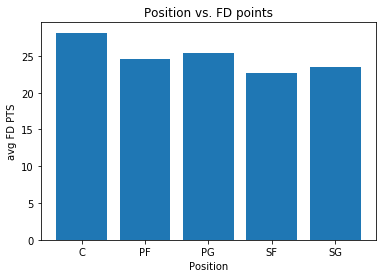

In [923]:
plt.bar(names, master_dataset.groupby('Position')['FD PTS'].mean())
plt.xlabel('Position')
plt.ylabel('avg FD PTS')
plt.title('Position vs. FD points')
plt.savefig(fname = 'Position_FDPT')

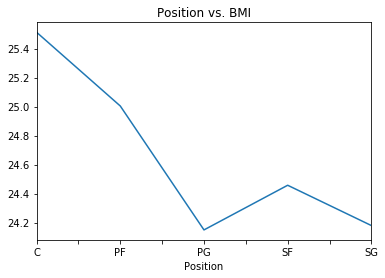

In [924]:
master_dataset.groupby('Position')['BMI'].mean().plot(title = 'Position vs. BMI')
plt.savefig('Position_BMI')

In [815]:
import datetime as dt
master_dataset['Date'] = pd.to_datetime(master_dataset['Date'])
master_dataset['Year'] = master_dataset['Date'].dt.year

In [872]:
a = (master_dataset.dtypes == int)
b = (master_dataset.dtypes == float)
typeint = list(a[a == True].index)
typeflt = list(b[b == True].index)
typefit = typeint + typeflt
y = master_dataset['FD PTS']

In [994]:
len(m_default2.columns)

17

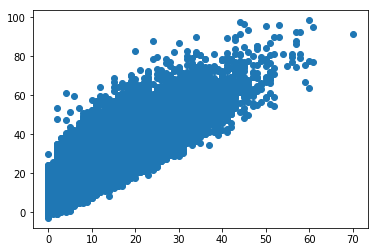

In [992]:
plt.scatter(master_dataset['PTS'], y) 

In [193]:
player_found_dataset = master_dataset.drop([i for i in master_dataset.columns if str(master_dataset[i].dtype) not in ['int64', 'float64']], axis=1)

cols_lst = ['PLAYER_ID', 'TEAM_ID', 'PLAYER_GAME_ID', 'Salary']
for col in range(4,len(player_found_dataset.columns)-1):
    
    cols_lst.append(player_found_dataset.columns[col])
cols_lst.append('FD PTS')

player_found_dataset = player_found_dataset[cols_lst]

In [194]:
player_found_dataset['PLAYER_ID'].head()

0    203081
1    200746
2    203613
3    203937
4    203473
Name: PLAYER_ID, dtype: int64

In [996]:
player_found_dataset.describe()

,PLAYER_ID,TEAM_ID,PLAYER_GAME_ID,Salary,MIN,PTS,FGM,FGA,FG_PCT,FG3M,...,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,AGE,DRAFT_NUMBER,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,BMI,FD PTS
count,5.929400e+04,5.929400e+04,59294.000000,59294.000000,59294.00000,59294.000000,59294.000000,59294.000000,59173.000000,59294.000000,...,59294.000000,59294.000000,59294.000000,59294.000000,59294.000000,59294.000000,59294.000000,59294.000000,59294.000000,59294.000000
mean,5.806517e+05,1.610613e+09,77.410075,5345.039532,26.99489,12.406803,4.589706,9.897426,0.461283,1.215654,...,99.203562,0.500130,0.141986,0.557064,26.940955,24.146355,79.017506,219.024488,24.598405,24.589335
std,6.506593e+05,8.700596e+00,57.234926,2010.522859,7.14329,7.942035,2.956274,5.273963,0.194445,1.423612,...,5.772766,0.048784,0.037617,0.060694,4.171763,19.318984,3.373614,24.621317,1.544175,12.766671
min,1.713000e+03,1.610613e+09,0.000000,0.000000,15.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,83.000000,0.333000,0.030000,0.350000,19.000000,1.000000,69.000000,150.000000,19.771875,-2.800000
25%,2.019430e+05,1.610613e+09,29.000000,3700.000000,21.00000,6.000000,2.000000,6.000000,0.333000,0.000000,...,95.000000,0.468000,0.116000,0.516000,24.000000,8.000000,76.000000,200.000000,23.654863,15.100000
50%,2.031150e+05,1.610613e+09,67.000000,4800.000000,27.00000,11.000000,4.000000,9.000000,0.462000,1.000000,...,99.000000,0.500000,0.140000,0.556000,27.000000,19.000000,79.000000,220.000000,24.543937,22.600000
75%,1.626159e+06,1.610613e+09,118.000000,6400.000000,33.00000,17.000000,6.000000,13.000000,0.571000,2.000000,...,103.000000,0.533000,0.167000,0.597000,30.000000,37.000000,82.000000,238.000000,25.613732,31.900000
max,1.629541e+06,1.610613e+09,243.000000,14300.000000,60.00000,70.000000,23.000000,44.000000,1.000000,14.000000,...,145.000000,0.667000,0.299000,0.788000,42.000000,61.000000,87.000000,290.000000,30.215199,98.500000


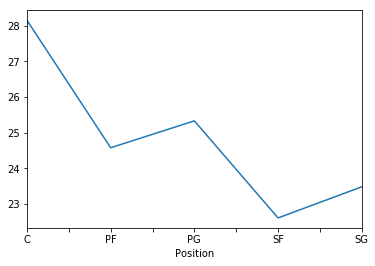

In [997]:
player_found_dataset.groupby('Position')['FD PTS'].mean().plot()

In [494]:
player_found_dataset2['Position'] = master_dataset['Position']

In [329]:
def total_rolling_avgs_col(df, col_name, avg_size):
    rolling_avgs = df.groupby('PLAYER_ID')[col_name].rolling(avg_size).mean()
    for i in range(0, avg_size):
        rolling_avgs = rolling_avgs.fillna(player_found_dataset2.groupby('PLAYER_ID')[col_name].rolling(i).mean())
    return rolling_avgs

In [197]:
%%time
test = total_rolling_avgs_col(player_found_dataset, 'PTS', 5)

CPU times: user 1.81 s, sys: 21.7 ms, total: 1.83 s
Wall time: 1.91 s


In [198]:
player_found_dataset.columns

Index(['PLAYER_ID', 'TEAM_ID', 'PLAYER_GAME_ID', 'Salary', 'MIN', 'PTS', 'FGM',
       'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS',
       'Home?', 'AST_PCT', 'AST_RATIO', 'AST_TO', 'DEF_RATING', 'DREB_PCT',
       'EFG_PCT', 'E_DEF_RATING', 'E_NET_RATING', 'E_OFF_RATING', 'E_PACE',
       'NET_RATING', 'OFF_RATING', 'OREB_PCT', 'PACE', 'PACE_PER40', 'PIE',
       'POSS', 'REB_PCT', 'TM_TOV_PCT', 'TS_PCT', 'AGE', 'DRAFT_NUMBER',
       'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 'BMI', 'FD PTS'],
      dtype='object')

In [285]:
default_dataset = player_found_dataset[['PLAYER_ID','TEAM_ID','PLAYER_GAME_ID', 'Salary', 'MIN', 'AGE', \
                                        'DRAFT_NUMBER', 'BMI', 'Home?']]

In [312]:
player_found_dataset.columns

Index(['PLAYER_ID', 'TEAM_ID', 'PLAYER_GAME_ID', 'Salary', 'MIN', 'PTS', 'FGM',
       'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS',
       'Home?', 'AST_PCT', 'AST_RATIO', 'AST_TO', 'DEF_RATING', 'DREB_PCT',
       'EFG_PCT', 'E_DEF_RATING', 'E_NET_RATING', 'E_OFF_RATING', 'E_PACE',
       'NET_RATING', 'OFF_RATING', 'OREB_PCT', 'PACE', 'PACE_PER40', 'PIE',
       'POSS', 'REB_PCT', 'TM_TOV_PCT', 'TS_PCT', 'AGE', 'DRAFT_NUMBER',
       'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 'BMI', 'FD PTS'],
      dtype='object')

In [337]:
toScaled = player_found_dataset[['Salary', 'MIN', 'PTS', 'FGM',
       'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS',
       'Home?', 'AST_PCT', 'AST_RATIO', 'AST_TO', 'DEF_RATING', 'DREB_PCT',
       'EFG_PCT', 'E_DEF_RATING', 'E_NET_RATING', 'E_OFF_RATING', 'E_PACE',
       'NET_RATING', 'OFF_RATING', 'OREB_PCT', 'PACE', 'PACE_PER40', 'PIE',
       'POSS', 'REB_PCT', 'TM_TOV_PCT', 'TS_PCT', 'FD PTS']]

In [338]:
len(toScaled.columns)

43

In [339]:
sc = StandardScaler()

In [340]:
player_found_dataset2 = pd.DataFrame(sc.fit_transform(toScaled), columns = toScaled.columns)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [341]:
player_found_dataset2['PLAYER_ID'] = player_found_dataset['PLAYER_ID']
player_found_dataset2['PLAYER_GAME_ID'] = player_found_dataset['PLAYER_GAME_ID']

In [497]:
player_found_dataset.columns

Index(['PLAYER_ID', 'TEAM_ID', 'PLAYER_GAME_ID', 'Salary', 'MIN', 'PTS', 'FGM',
       'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS',
       'Home?', 'AST_PCT', 'AST_RATIO', 'AST_TO', 'DEF_RATING', 'DREB_PCT',
       'EFG_PCT', 'E_DEF_RATING', 'E_NET_RATING', 'E_OFF_RATING', 'E_PACE',
       'NET_RATING', 'OFF_RATING', 'OREB_PCT', 'PACE', 'PACE_PER40', 'PIE',
       'POSS', 'REB_PCT', 'TM_TOV_PCT', 'TS_PCT', 'AGE', 'DRAFT_NUMBER',
       'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 'BMI', 'FD PTS', 'Position'],
      dtype='object')

In [409]:
def roll_avgs_col_maker(df, col_name, avg_size):
    new_df = pd.DataFrame(df[['PLAYER_ID', 'PLAYER_GAME_ID']])
    rolling_avgs = total_rolling_avgs_col(df, col_name, avg_size)
    indices = [rolling_avgs.index[i][1] for i in range(len(test.index))]
    new_df['{}_LAST_{}'.format(col_name, avg_size)] = pd.Series(dict(zip(indices, rolling_avgs.values))).sort_index()
    return new_df

In [653]:
roll_avgs_dataset = roll_avgs_col_maker(player_found_dataset2, 'PTS', 5)

In [654]:
roll_avgs_dataset.head()

,PLAYER_ID,PLAYER_GAME_ID,PTS_LAST_5
0,203081,0,3.348439
1,200746,0,1.711565
2,203613,0,0.956085
3,203937,0,-1.184442
4,203473,0,-1.310356


In [655]:
avg_cols = ['PACE', 'PIE', 'OFF_RATING', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'FD PTS', 'Home?']

In [656]:
for i in avg_cols:
    newdf = roll_avgs_col_maker(player_found_dataset2, i, 5)
    roll_avgs_dataset = roll_avgs_dataset.merge(newdf, on = ["PLAYER_ID", "PLAYER_GAME_ID"])

In [657]:
for i in ['FD PTS', 'PTS']:
    newdf = roll_avgs_col_maker(player_found_dataset2, i, 10)
    roll_avgs_dataset = roll_avgs_dataset.merge(newdf, on = ["PLAYER_ID", "PLAYER_GAME_ID"])

In [658]:
y = player_found_dataset['FD PTS']

In [659]:
roll_avgs_dataset.head()

,PLAYER_ID,PLAYER_GAME_ID,PTS_LAST_5,PACE_LAST_5,PIE_LAST_5,OFF_RATING_LAST_5,REB_LAST_5,AST_LAST_5,STL_LAST_5,BLK_LAST_5,TOV_LAST_5,FD PTS_LAST_5,Home?_LAST_5,FD PTS_LAST_10,PTS_LAST_10
0,203081,0,3.348439,-1.398638,0.529455,1.268042,1.147571,1.273473,-0.846599,-0.610708,1.713340,2.366390,1.001958,2.366390,3.348439
1,200746,0,1.711565,0.379658,1.107059,1.820622,2.560534,0.120160,0.136331,-0.610708,0.330870,1.778918,-0.998046,1.778918,1.711565
2,203613,0,0.956085,0.379658,1.107059,1.820622,-0.265392,0.120160,-0.846599,0.518883,0.330870,0.368985,-0.998046,0.368985,0.956085
3,203937,0,-1.184442,0.379658,1.107059,1.820622,-0.265392,-1.033152,0.136331,-0.610708,-1.051599,-1.158443,-0.998046,-1.158443,-1.184442
4,203473,0,-1.310356,0.379658,1.107059,1.820622,0.864978,-1.033152,0.136331,1.648474,-0.360364,-0.625802,-0.998046,-0.625802,-1.310356


In [743]:
m_default = default_dataset.merge(roll_avgs_dataset, 
                                  on = ["PLAYER_ID", "PLAYER_GAME_ID"]).drop(['PLAYER_GAME_ID'], axis = 1)

In [744]:
m_default.columns

Index(['PLAYER_ID', 'TEAM_ID', 'Salary', 'MIN', 'AGE', 'DRAFT_NUMBER', 'BMI',
       'Home?', 'PTS_LAST_5', 'PACE_LAST_5', 'PIE_LAST_5', 'OFF_RATING_LAST_5',
       'REB_LAST_5', 'AST_LAST_5', 'STL_LAST_5', 'BLK_LAST_5', 'TOV_LAST_5',
       'FD PTS_LAST_5', 'Home?_LAST_5', 'FD PTS_LAST_10', 'PTS_LAST_10'],
      dtype='object')

In [745]:
m_default['Position'] = master_dataset['Position']

In [746]:
oneHot = pd.get_dummies(m_default[['Position']])

In [747]:
# oneHot_playerid = pd.get_dummies(m_default[['PLAYER_ID']].astype(str))

In [748]:
m_default['Position_C'] = oneHot['Position_C']
m_default['Position_PF'] = oneHot['Position_PF']
m_default['Position_PG'] = oneHot['Position_PG']
m_default['Position_SF'] = oneHot['Position_SF']
m_default['Position_SG'] = oneHot['Position_SG']

In [749]:
# m_default = pd.concat([oneHot_playerid, m_default], axis = 1).drop(['PLAYER_ID'], axis = 1)

In [750]:
m_default.columns

Index(['PLAYER_ID', 'TEAM_ID', 'Salary', 'MIN', 'AGE', 'DRAFT_NUMBER', 'BMI',
       'Home?', 'PTS_LAST_5', 'PACE_LAST_5', 'PIE_LAST_5', 'OFF_RATING_LAST_5',
       'REB_LAST_5', 'AST_LAST_5', 'STL_LAST_5', 'BLK_LAST_5', 'TOV_LAST_5',
       'FD PTS_LAST_5', 'Home?_LAST_5', 'FD PTS_LAST_10', 'PTS_LAST_10',
       'Position', 'Position_C', 'Position_PF', 'Position_PG', 'Position_SF',
       'Position_SG'],
      dtype='object')

In [751]:
m_default = m_default.drop('Position', axis =1)

In [974]:
len(m_default.columns)

26

In [435]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [254]:
from sklearn.metrics import mean_squared_error

In [752]:
m_default2 = m_default.drop(['PLAYER_ID', 'TEAM_ID', 'AGE', 'DRAFT_NUMBER', 'BMI', 'Home?'
                             , 'PACE_LAST_5', 'OFF_RATING_LAST_5', 'Home?_LAST_5'], axis = 1)

In [753]:
m_default2.columns

Index(['Salary', 'MIN', 'PTS_LAST_5', 'PIE_LAST_5', 'REB_LAST_5', 'AST_LAST_5',
       'STL_LAST_5', 'BLK_LAST_5', 'TOV_LAST_5', 'FD PTS_LAST_5',
       'FD PTS_LAST_10', 'PTS_LAST_10', 'Position_C', 'Position_PF',
       'Position_PG', 'Position_SF', 'Position_SG'],
      dtype='object')

In [555]:
# nominal_feat = ['PLAYER_ID', 'TEAM_ID']
# pl = Pipeline(steps = [('onehot', OneHotEncoder(sparse = True)), ('lr', LinearRegression())])
# col = ColumnTransformer(transformers = [('pl', pl, nominal_feat)])
# final = Pipeline(steps=[('pre', col)])
# final.fit(m_default2)
# final.transform(m_default2).toarray()

In [754]:
for i in m_default2.columns:
    X_train, X_test, y_train, y_test = train_test_split(m_default2[[i]], y, test_size = 0.35)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    pred = lr.predict(X_test)
    print('Column name: ', i, " score: ", lr.score(X_test, y_test))
    print("mse: ", mean_squared_error(pred, y_test))

Column name:  Salary  score:  0.4512500899873706
mse:  89.90521050505274
Column name:  MIN  score:  0.4569743924414873
mse:  86.83228032035478
Column name:  PTS_LAST_5  score:  0.48930191119815836
mse:  83.61907587838199
Column name:  PIE_LAST_5  score:  0.009906808204087738
mse:  163.6329749615328
Column name:  REB_LAST_5  score:  0.2432261962316855
mse:  121.87402978519317
Column name:  AST_LAST_5  score:  0.21149647615528944
mse:  128.43363303959845
Column name:  STL_LAST_5  score:  0.12509904656401338
mse:  142.34938512195768
Column name:  BLK_LAST_5  score:  0.09039244757493237
mse:  147.45176098454277
Column name:  TOV_LAST_5  score:  0.21831248817232396
mse:  126.35038831065987
Column name:  FD PTS_LAST_5  score:  0.6277623339950961
mse:  61.09613602334323
Column name:  FD PTS_LAST_10  score:  0.5885283828334695
mse:  67.38583873560324
Column name:  PTS_LAST_10  score:  0.4533510861978246
mse:  89.14207610456809
Column name:  Position_C  score:  0.012063978903324224
mse:  159.52

In [761]:
X_train, X_test, y_train, y_test = train_test_split(m_default2, y, test_size = 0.35)

In [762]:
lr = LinearRegression(fit_intercept=True)

In [763]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [764]:
pred = lr.predict(X_test)

In [765]:
lr.score(X_test, y_test)

0.7038713865510818

In [766]:
mean_squared_error(pred, y_test)

47.960389248581116